## Import Statements

In [177]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

from prophet import Prophet
import xgboost

from sklearn.model_selection import TimeSeriesSplit


In [178]:
#Notes

# Building prediction models based on global data and internal data and putting them together with the ensemble model
#internal_data_13_09.csv

## Getting Data

In [179]:
internal_data = pd.read_csv("./internal_data_13_09.csv")

external_data = pd.DataFrame()

In [180]:
internal_data.head()

,Unnamed: 0,month_normalized,month,countryname,sales_actuals_monthly__vehiclegroup01__orderintake,sales_actuals_monthly__vehiclegroup01__retail,customer_vehicle_relationships__vehiclegroup01__terminated_cars,customer_vehicle_relationships__vehiclegroup01__active_cars,leasing_contracts__vehiclegroup01__end,leasing_contracts__vehiclegroup01__start,...,premises__vehiclegroup01__in_sales_fill_zero,premises__vehiclegroup01__flag_production_start_meanbymonth,premises__vehiclegroup01__flag_production_start_interpolated_linear,premises__vehiclegroup01__flag_production_start_fill_zero,premises__vehiclegroup01__in_production_meanbymonth,premises__vehiclegroup01__in_production_interpolated_linear,premises__vehiclegroup01__in_production_fill_zero,quota__vehiclegroup01__aq_meanbymonth,quota__vehiclegroup01__aq_interpolated_linear,quota__vehiclegroup01__aq_fill_zero
0,0,1,1,Country A,296.0,352.0,0.0,25.0,0.0,81.0,...,0.0,11.111111,0.0,0.0,351.888889,0.0,0.0,182.5625,83.0,0.0
1,1,2,2,Country A,414.0,372.0,1.0,102.0,4.0,130.0,...,0.0,55.555556,0.0,0.0,363.222222,0.0,0.0,287.3750,83.0,0.0
2,2,3,3,Country A,405.0,604.0,2.0,152.0,2.0,145.0,...,0.0,5.555556,0.0,0.0,356.000000,0.0,0.0,345.0000,83.0,0.0
3,3,4,4,Country A,359.0,483.0,2.0,75.0,2.0,183.0,...,0.0,83.333333,0.0,0.0,374.555556,0.0,0.0,329.4375,83.0,0.0
4,4,5,5,Country A,403.0,474.0,10.0,91.0,4.0,201.0,...,0.0,72.222222,0.0,0.0,393.055556,0.0,0.0,343.5000,83.0,0.0


## Data cleaning

In [181]:
internal_data = internal_data.drop(["Unnamed: 0", "month", "countryname",  "premises__vehiclegroup01__in_sales_fill_zero", "premises__vehiclegroup01__flag_production_start_interpolated_linear", "premises__vehiclegroup01__flag_production_start_fill_zero", "premises__vehiclegroup01__in_production_interpolated_linear", "premises__vehiclegroup01__in_production_fill_zero", "quota__vehiclegroup01__aq_interpolated_linear", "quota__vehiclegroup01__aq_fill_zero"], axis = 1)


In [182]:
internal_data.shape

(258, 36)

## Data Preperation

In [183]:
#Splitting into target/feature data
y = internal_data.loc[:, "sales_actuals_monthly__vehiclegroup01__orderintake"]
X_internal = internal_data.drop("sales_actuals_monthly__vehiclegroup01__orderintake", axis = 1)
X_external = external_data

In [184]:
X_internal.shape

(258, 35)

In [185]:
#Cut the first 60 columns for internal data, since the internal data is quite lacking
X_internal = X_internal.iloc[60:,:]
X_internal = X_internal.reset_index(drop = "Index")

In [186]:
X_internal_train = X_internal.iloc[:180,:]
X_internal_test = X_internal.iloc[180:, :]

y_train = y.iloc[60:240]
y_test = y.iloc[240:]

In [187]:
y_train.head()
y_train = y_train.reset_index(drop = "Index")

## Prophet

In [188]:
X_pro = X_internal.copy()
X_pro["y"] = y.copy()

X_pro["ds"] = X_pro.index

# Convert the 'ds' column to datetime format
start_date = '2000-01-01'  # Adjust this date to your needs
X_pro['ds'] = pd.to_datetime(X_pro['ds'].apply(lambda x: pd.DateOffset(months=x) + pd.Timestamp(start_date)))


In [189]:
X_pro_train = X_pro.iloc[:180, :]
X_pro_test = X_pro.iloc[180:, :]
X_pro.shape

X_pro_test.tail()

,month_normalized,sales_actuals_monthly__vehiclegroup01__retail,customer_vehicle_relationships__vehiclegroup01__terminated_cars,customer_vehicle_relationships__vehiclegroup01__active_cars,leasing_contracts__vehiclegroup01__end,leasing_contracts__vehiclegroup01__start,sales_flow_monthly__vehiclegroup01__cp8_meanbymonth,sales_flow_monthly__vehiclegroup01__cp8_interpolated_linear,sales_flow_monthly__vehiclegroup01__cp8_fill_zero,sales_stock_monthly__vehiclegroup01__physical_meanbymonth,...,premises__vehiclegroup01__flag_order_start_meanbymonth,premises__vehiclegroup01__flag_order_start_interpolated_linear,premises__vehiclegroup01__flag_order_start_fill_zero,premises__vehiclegroup01__in_sales_meanbymonth,premises__vehiclegroup01__in_sales_interpolated_linear,premises__vehiclegroup01__flag_production_start_meanbymonth,premises__vehiclegroup01__in_production_meanbymonth,quota__vehiclegroup01__aq_meanbymonth,y,ds
193,2,247.0,371.0,673.0,319.0,158.0,297.0,297.0,297.0,326.0,...,333.0,333.0,333.0,472.0,472.0,0.0,385.0,238.0,387.0,2016-02-01
194,3,553.0,498.0,932.0,592.0,334.0,457.0,457.0,457.0,351.0,...,0.0,0.0,0.0,472.0,472.0,100.0,410.0,393.0,449.0,2016-03-01
195,4,450.0,521.0,798.0,615.0,332.0,436.0,436.0,436.0,492.0,...,0.0,0.0,0.0,472.0,472.0,0.0,410.0,462.0,320.0,2016-04-01
196,5,735.0,512.0,721.0,693.0,394.0,283.0,283.0,283.0,329.0,...,0.0,0.0,0.0,472.0,472.0,0.0,410.0,503.0,283.0,2016-05-01
197,6,475.0,494.0,871.0,831.0,369.0,365.0,365.0,365.0,228.0,...,1000.0,1000.0,1000.0,639.0,639.0,0.0,410.0,451.0,103.0,2016-06-01


In [190]:
m = Prophet()

# Fit the model with train set
m.fit(X_pro_train)

future = m.make_future_dataframe(periods=18, freq = "MS")

# Make predictions on the test set dates
forecast_pro = m.predict(future)

forecast_pro = forecast_pro.iloc[180:,:]

#forecast_pro = forecast_pro.iloc[240:, :]

# Calculate errors
mse = mean_squared_error(X_pro_test['y'], forecast_pro['yhat'])
mae = mean_absolute_error(X_pro_test['y'], forecast_pro['yhat'])

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

15:54:23 - cmdstanpy - INFO - Chain [1] start processing
15:54:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 43231.5612537788
Mean Absolute Error: 145.96461223939994


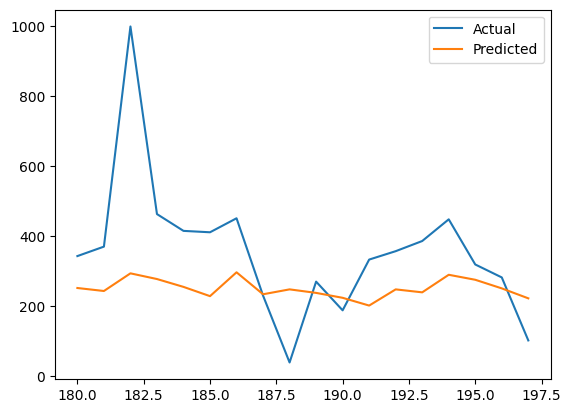

In [191]:

# Create a new figure
plt.figure()

# Plot y_test
plt.plot(X_pro_test["y"] , label='Actual')

# Plot y_pred
plt.plot(forecast_pro["yhat"], label='Predicted')

# Add a legend
plt.legend()

# Show the plot
plt.show()

## XGBRegressor

In [192]:
#Deviding data in lag/no-lag for the Regression
X_internal_no_lag = X_internal[["leasing_contracts__vehiclegroup01__end", "leasing_contracts__vehiclegroup01__start"]]
X_internal_lag = X_internal.drop(["leasing_contracts__vehiclegroup01__end", "leasing_contracts__vehiclegroup01__start"], axis = 1)

In [205]:
lag = 18

y_train_XGB = y.iloc[60 + lag:-lag]
y_test_XGB = y.iloc[-lag:]

X_train_XGB = X_internal_lag.iloc[:-lag*2, :]
X_test_XGB = X_internal_lag.iloc[-lag*2:-lag, :]

print(y_train_XGB.shape)
print(y_test_XGB.shape) 
print(X_train_XGB.shape)
print(X_test_XGB.shape)

(162,)
(18,)
(162, 33)
(18, 33)


In [206]:
#Getting k-fold cross validation for time series ready
X_kfold = []
y_kfold = []

n_splits = 11

for n in range(1, n_splits + 1):
    X_kfold.append(X_train_XGB.iloc[:n*18])
    y_kfold.append(y_train_XGB.iloc[:n*18])

X_kfold[0].head()


,month_normalized,sales_actuals_monthly__vehiclegroup01__retail,customer_vehicle_relationships__vehiclegroup01__terminated_cars,customer_vehicle_relationships__vehiclegroup01__active_cars,sales_flow_monthly__vehiclegroup01__cp8_meanbymonth,sales_flow_monthly__vehiclegroup01__cp8_interpolated_linear,sales_flow_monthly__vehiclegroup01__cp8_fill_zero,sales_stock_monthly__vehiclegroup01__physical_meanbymonth,sales_stock_monthly__vehiclegroup01__physical_interpolated_linear,sales_stock_monthly__vehiclegroup01__physical_fill_zero,...,leads__vehiclegroup01__lost_interpolated_linear,leads__vehiclegroup01__lost_fill_zero,premises__vehiclegroup01__flag_order_start_meanbymonth,premises__vehiclegroup01__flag_order_start_interpolated_linear,premises__vehiclegroup01__flag_order_start_fill_zero,premises__vehiclegroup01__in_sales_meanbymonth,premises__vehiclegroup01__in_sales_interpolated_linear,premises__vehiclegroup01__flag_production_start_meanbymonth,premises__vehiclegroup01__in_production_meanbymonth,quota__vehiclegroup01__aq_meanbymonth
0,1,297.0,122.0,232.0,175.888889,2.0,0.0,495.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,308.0,182.5625
1,2,240.0,111.0,212.0,245.888889,2.0,0.0,513.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,308.0,287.3750
2,3,407.0,131.0,248.0,273.800000,2.0,0.0,473.777778,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,345.0000
3,4,697.0,163.0,332.0,270.100000,2.0,0.0,420.444444,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,256.0,329.4375
4,5,531.0,154.0,224.0,268.400000,2.0,0.0,372.555556,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,343.5000


In [207]:
# Train a XGBClassifier
for i in range(n_splits):
    xgb_sub_1 = xgboost.XGBRegressor(use_label_encoder=False, eval_metric="mae").fit(X_kfold[i], y_kfold[i])

In [208]:
y_test_XGB = y_test_XGB.reset_index()
y_test_XGB = y_test_XGB.drop("index", axis = 1)

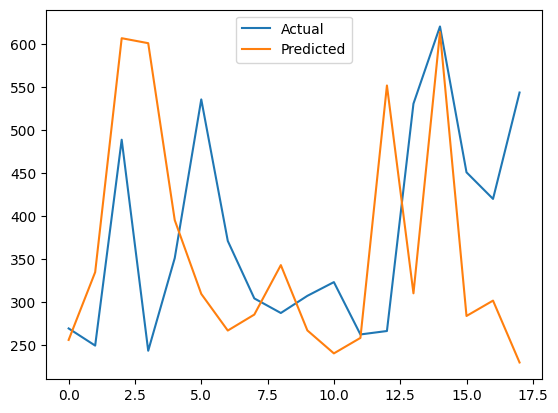

In [209]:
forecast_xgb = xgb_sub_1.predict(X_test_XGB)

# Create a new figure
plt.figure()

# Plot y_test
plt.plot(y_test_XGB , label='Actual')

# Plot y_pred
plt.plot(forecast_xgb, label='Predicted')

# Add a legend
plt.legend()

# Show the plot
plt.show()

## SARIMA

In [198]:
#Placeholder

## Ensemble XGBRegressor

In [199]:
#Data Preperation for ensemble model

X_meta = pd.merge(forecast_pro["yhat"], forecast_xgb)

TypeError: merge() missing 2 required positional arguments: 'left' and 'right'

In [ ]:
xgb_sub_1 = xgboost.XGBRegressor(use_label_encoder=False, eval_metric="mae").fit(X_train_XGB, y_train_XGB)